In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

2022-08-12 12:32:15.218833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [7]:
names = [
    'Maximum/Composite radar reflectivity:dB (instant):lambert:atmosphere:level 0',
    'MSLP (MAPS System Reduction):Pa (instant):lambert:meanSea:level 0',
    'AGL reflectivity (max):lambert:heightAboveGround:level 1000 m',
    'Updraft helicity (max):lambert:heightAboveGroundLayer:levels 5000-2000 m',
    'Updraft helicity (max):lambert:heightAboveGroundLayer:levels 2000-0 m',
    'Updraft helicity (max):lambert:heightAboveGroundLayer:levels 3000-0 m',
    'Vorticity (relative):s**-1 (max):lambert:heightAboveGroundLayer:levels 2000-0 m',
    'Vorticity (relative):s**-1 (max):lambert:heightAboveGroundLayer:levels 1000-0 m',
    'Column integrated graupel mass (max):lambert:atmosphereSingleLayer:level 0 considered as a single layer',
    '2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m',
    '2 metre dewpoint temperature:K (instant):lambert:heightAboveGround:level 2 m',
    '10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m',
    '10 metre V wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m',
    '10 metre wind speed:m s**-1 (max):lambert:heightAboveGround:level 10 m',
    'Total Precipitation:kg m**-2 (accum):lambert:surface:level 0',
    'Convective available potential energy:J kg**-1 (instant):lambert:surface:level 0',
    'Convective inhibition:J kg**-1 (instant):lambert:surface:level 0',
    'Storm relative helicity:J kg**-1 (instant):lambert:heightAboveGroundLayer:levels 3000-0 m',
    'Storm relative helicity:J kg**-1 (instant):lambert:heightAboveGroundLayer:levels 1000-0 m',
    'Vertical u-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-1000 m',
    'Vertical v-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-1000 m',
    'Vertical u-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-6000 m',
    'Vertical v-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-6000 m'
]

name_pick = []
for i in [0, 1, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]:
    #print(names[i])
    name_pick.append(names[i])
    
name_pick.append('Climatology')

In [11]:
flag_pick = [0, 13, 1, 5, 17, 18, 12, 11]

In [12]:
for i in flag_pick:
    print(name_pick[i])

Maximum/Composite radar reflectivity:dB (instant):lambert:atmosphere:level 0
Storm relative helicity:J kg**-1 (instant):lambert:heightAboveGroundLayer:levels 3000-0 m
MSLP (MAPS System Reduction):Pa (instant):lambert:meanSea:level 0
2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m
Vertical u-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-6000 m
Vertical v-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-6000 m
Convective inhibition:J kg**-1 (instant):lambert:surface:level 0
Convective available potential energy:J kg**-1 (instant):lambert:surface:level 0


In [13]:
filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))[::10]

In [15]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)
L_vars = len(flag_pick)

VALID_input = np.empty((L_valid,)+grid_shape+(L_vars,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    for c, v in enumerate(flag_pick):
        VALID_input[i, ..., c] = data[..., v]

In [16]:
IN = tf.keras.Input((128, 128, 8))

X = IN

X = k_layers.CONV_stack(X, 32, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(32, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 64, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(64, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 128, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(128, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 256, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(256, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

X = k_layers.CONV_stack(X, 512, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack5')
X = tf.keras.layers.Conv2D(512, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv5')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)
#D = tf.keras.layers.Softmax()(D)

OUT = D

2022-08-12 12:40:11.039416: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-12 12:40:11.040970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-12 12:40:11.086060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-12 12:40:11.086116: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-12 12:40:11.189930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-12 12:40:11.189969: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [17]:
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=2e-5))

In [18]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100
batch_size_half = 50

valid_size = 1

In [25]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'VGG8_tornado'

model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

In [21]:
X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [22]:
#Y_pred = model.predict([VALID_X])
record = 1.0 #np.nanmean(np.abs(Y_pred-VALID_Y))
print("Initial record: {}".format(record))

Initial record: 1.0


In [23]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
from sklearn.metrics import classification_report, auc, roc_curve

In [26]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            for c, v in enumerate(flag_pick):
                X_batch[k, ..., c] = data[..., v]
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))
        
        # Soft labelling
        Y_batch[:batch_size_half, :] = np.random.uniform(0.95, 0.99, size=(batch_size_half, 1))
        Y_batch[batch_size_half:, :] = np.random.uniform(0.01, 0.05, size=(batch_size_half, 1))
        
        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input,])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


2022-08-12 12:47:30.791641: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-12 12:47:30.799847: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-08-12 12:47:31.082639: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-12 12:47:31.898950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Validation loss 0.18139294913815562 NOT improved
Validation loss 0.1276521621746548 NOT improved
Validation loss 0.10038211252720852 NOT improved
Validation loss 0.0931886954886586 NOT improved
Validation loss improved from 1.0 to 0.09779239047306887
save to: /glade/work/ksha/NCAR/Keras_models/VGG8_tornado_pp20


2022-08-12 13:10:22.582484: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG8_tornado_pp20/assets
--- 283.86511611938477 seconds ---
Validation loss 0.0997273776357479 NOT improved
Validation loss improved from 0.09779239047306887 to 0.09656919442133316
save to: /glade/work/ksha/NCAR/Keras_models/VGG8_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG8_tornado_pp20/assets
--- 259.29671263694763 seconds ---
Validation loss 0.10036681436939565 NOT improved
Validation loss improved from 0.09656919442133316 to 0.09457984298968802
save to: /glade/work/ksha/NCAR/Keras_models/VGG8_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG8_tornado_pp20/assets
--- 257.8850591182709 seconds ---
Validation loss improved from 0.09457984298968802 to 0.09199294420072435
save to: /glade/work/ksha/NCAR/Keras_models/VGG8_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG8_tornado_pp20/assets
--- 264.625566

KeyboardInterrupt: 

In [43]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'VGG8_tornado'

model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-6))

model_name = '{}_pp20_tune'.format(key)
model_path = temp_dir+model_name

In [44]:
Y_pred = model.predict([VALID_input,])

fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
record_temp = auc(fpr, tpr)
record_temp = 1 - record_temp

print(record_temp)

0.08218321388951921


In [45]:
auc(fpr, tpr)

0.9178167861104808

In [46]:
VALID_label.ravel()

array([1., 1., 1., ..., 0., 0., 0.])

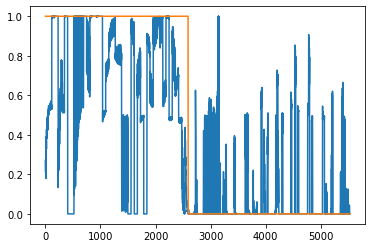

In [47]:
plt.plot(Y_pred.ravel())
plt.plot(VALID_label.ravel())

In [41]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            for c, v in enumerate(flag_pick):
                X_batch[k, ..., c] = data[..., v]
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))
        
        # Soft labelling
        Y_batch[:batch_size_half, :] = np.random.uniform(0.95, 0.99, size=(batch_size_half, 1))
        Y_batch[batch_size_half:, :] = np.random.uniform(0.01, 0.05, size=(batch_size_half, 1))
        
        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input,])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Validation loss 0.09713896872820171 NOT improved
Validation loss 0.10084762299456251 NOT improved
Validation loss 0.1008530068955954 NOT improved
Validation loss 0.10472987524056843 NOT improved


KeyboardInterrupt: 

In [50]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'TH_chad'
model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [9]:
from sklearn.metrics import classification_report, auc, roc_curve

In [53]:
#filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
#filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [54]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)
L_vars = 20
L_sparse = len(flag_sparse)
L_dense = L_vars - L_sparse

VALID_sparse = np.empty((L_valid,)+grid_shape+(L_sparse,))
VALID_dense = np.empty((L_valid,)+grid_shape+(L_dense,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    count0 = 0
    count1 = 0
    for v in range(L_vars):
        if v in flag_sparse:
            VALID_sparse[i, ..., count0] = data[..., v]
            count0 += 1
        else:
            VALID_dense[i, ..., count1] = data[..., v]
            count1 += 1

In [60]:
VALID_label

array([1., 1., 1., ..., 0., 0., 0.])

In [55]:
# filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
# label_pos = np.ones(len(filename_valid_pos))
# label_neg = np.zeros(len(filename_valid_neg))
# VALID_label_skew = np.hstack([label_pos, label_neg])

# L_valid = len(VALID_label_skew)

# VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

# for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
#     data = np.load(filename)
#     VALID_skew[i, ...] = data[...]

**Balanced verif**

In [56]:
Y_pred = model.predict([VALID_dense, VALID_sparse])
Y_pred_label = Y_pred > 0.5

2022-08-11 17:58:34.004253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 47110422528 exceeds 10% of free system memory.


In [48]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.78      0.83     33142
        True       0.72      0.84      0.77     22154

    accuracy                           0.80     55296
   macro avg       0.80      0.81      0.80     55296
weighted avg       0.81      0.80      0.80     55296



In [17]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8871815021742365

In [18]:
fpr.shape

(17970,)

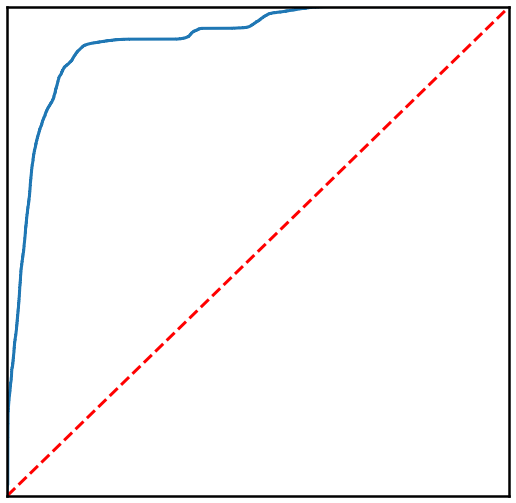

In [61]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

**Natural verif**

In [25]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5
print(classification_report(Y_pred_label.ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.97      0.92     26640
        True       0.67      0.33      0.44      5328

    accuracy                           0.86     31968
   macro avg       0.78      0.65      0.68     31968
weighted avg       0.84      0.86      0.84     31968



In [26]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8685229089653266

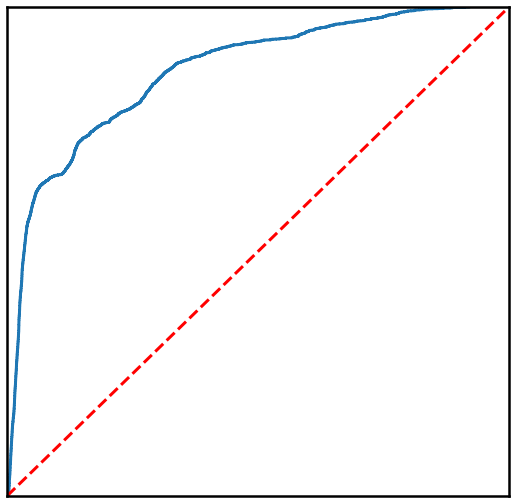

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

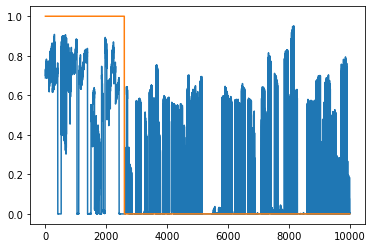

In [40]:
plt.plot(Y_pred.ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])

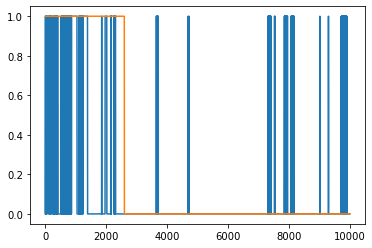

In [42]:
plt.plot(Y_pred.ravel()[:10000]>0.7)
plt.plot(VALID_label_skew.ravel()[:10000])